# Sample Analysis for Tracker Observables

Begin by importing the code, which I outsouced into `mycode.py` to keep this notebook nice and clean. 

In [1]:
from mycode import *

## Load Data and Prepare Weights

To load the data, we initialize a class `Analyzer`.
- If `inputfile` is not `None`, then the muon and neutrino spectra are just read from that file. This is the fast option. 
- Otherwise, the class loads all the data from the `/NumpyArrays` directory and compute the event weights. In this case you can save the data in an `outputfile` so that one can easily load it later on. 

In [2]:
analyser = Analyzer(prepare_nuel=True)

Prepare Data Manually
 ... found 205652 numu events in 5.47 seconds
 ... found 53357 nue events in 2.14 seconds
 ... found 5402058 muon events in 190.44 seconds


Now, we can look at the statistics of muons. The following table shows the weight of individual muons in units of fb. So if this number is 0.2, then our MC statistics correspond the expected event rate for 5 fb$^{-1}$, and if it is 0.0066,then our MC statistics correspond the expected event rate for 150 fb$^{-1}$. 

In [3]:
analyser.get_muon_statistics()

121.119 : 3.296
327.154 : 0.769
524.136 : 0.215
721.13 : 0.079
924.133 : 0.07
1124.14 : 0.108
1324.14 : 0.115
1524.14 : 0.084
1724.13 : 0.051
1924.14 : 0.031
2124.14 : 0.024
2324.14 : 0.025
2521.12 : 0.024
2721.12 : 0.015
2921.12 : 0.012
3121.12 : 0.007
3321.12 : 0.003
3521.12 : 0.003


## Plot Individual Events

An individual event is characterized by a dictionary of its properties:
- `primaryEnergy` which is the energy of the incoming muon
- `zposition` indicating where the neutrino interacted (number meaningless for muons)
- `scintillator` indicating which scintillators where activated
- `calorimeter` giving the energy deposit in the calorimeter
- `hits1 ... hits4`: giving the coordinates of hits in the tracker
- `weight`: giving the event weight in units of `fb`
Let's look at one muon neutrino event:

In [4]:
print (analyser.numu_data[10])

{'primaryEnergy': 3595.365, 'zposition': 98.2, 'weight': 6.49022534931631e-05, 'scintillator': array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1]), 'calorimeter': 4.636, 'hits1': array([[  0., -11.,   1.],
       [ -7.,   1.,   2.],
       [  0.,   2.,   7.],
       [ -6.,   6.,   1.],
       [ -5.,   6.,   1.],
       [ -8.,   7.,   1.],
       [-11.,   9.,   1.],
       [ -5.,   9.,   1.],
       [ -4.,   9.,   1.],
       [ -2.,   9.,   1.],
       [ -5.,  10.,   2.],
       [ -4.,  10.,   5.],
       [ -3.,  10.,   3.],
       [ -2.,  10.,   1.],
       [ -5.,  11.,   3.],
       [ -4.,  11.,   2.],
       [ -3.,  11.,   2.],
       [ -1.,  11.,   1.],
       [  3.,  11.,   1.],
       [ -5.,  12.,   1.],
       [ -4.,  12.,   1.],
       [ -1.,  12.,   1.]]), 'hits2': array([[-5., 10.,  1.]]), 'hits3': array([[ 2., -9.,  1.],
       [-4., -3.,  1.],
       [ 6.,  7.,  2.],
       [-5.,  9.,  1.],
       [-4.,  9.,  1.],
       [-5., 10.,  9.],
       [-4., 10.,  2.],
       [-5., 11.,  1.]]), '

Since the above format is a bit hard to read, we can also plot individual events. If you want to see a particular event, you can use `Analyser.display_event(event,filename)`. Alternatively, one can also use `Analyser.display_random_event(particle, requirement)` with particle being `muon`, `nu_mu` or `nu_el`. Here `requirement` adds some additional cuts on the event, when selecting it. 

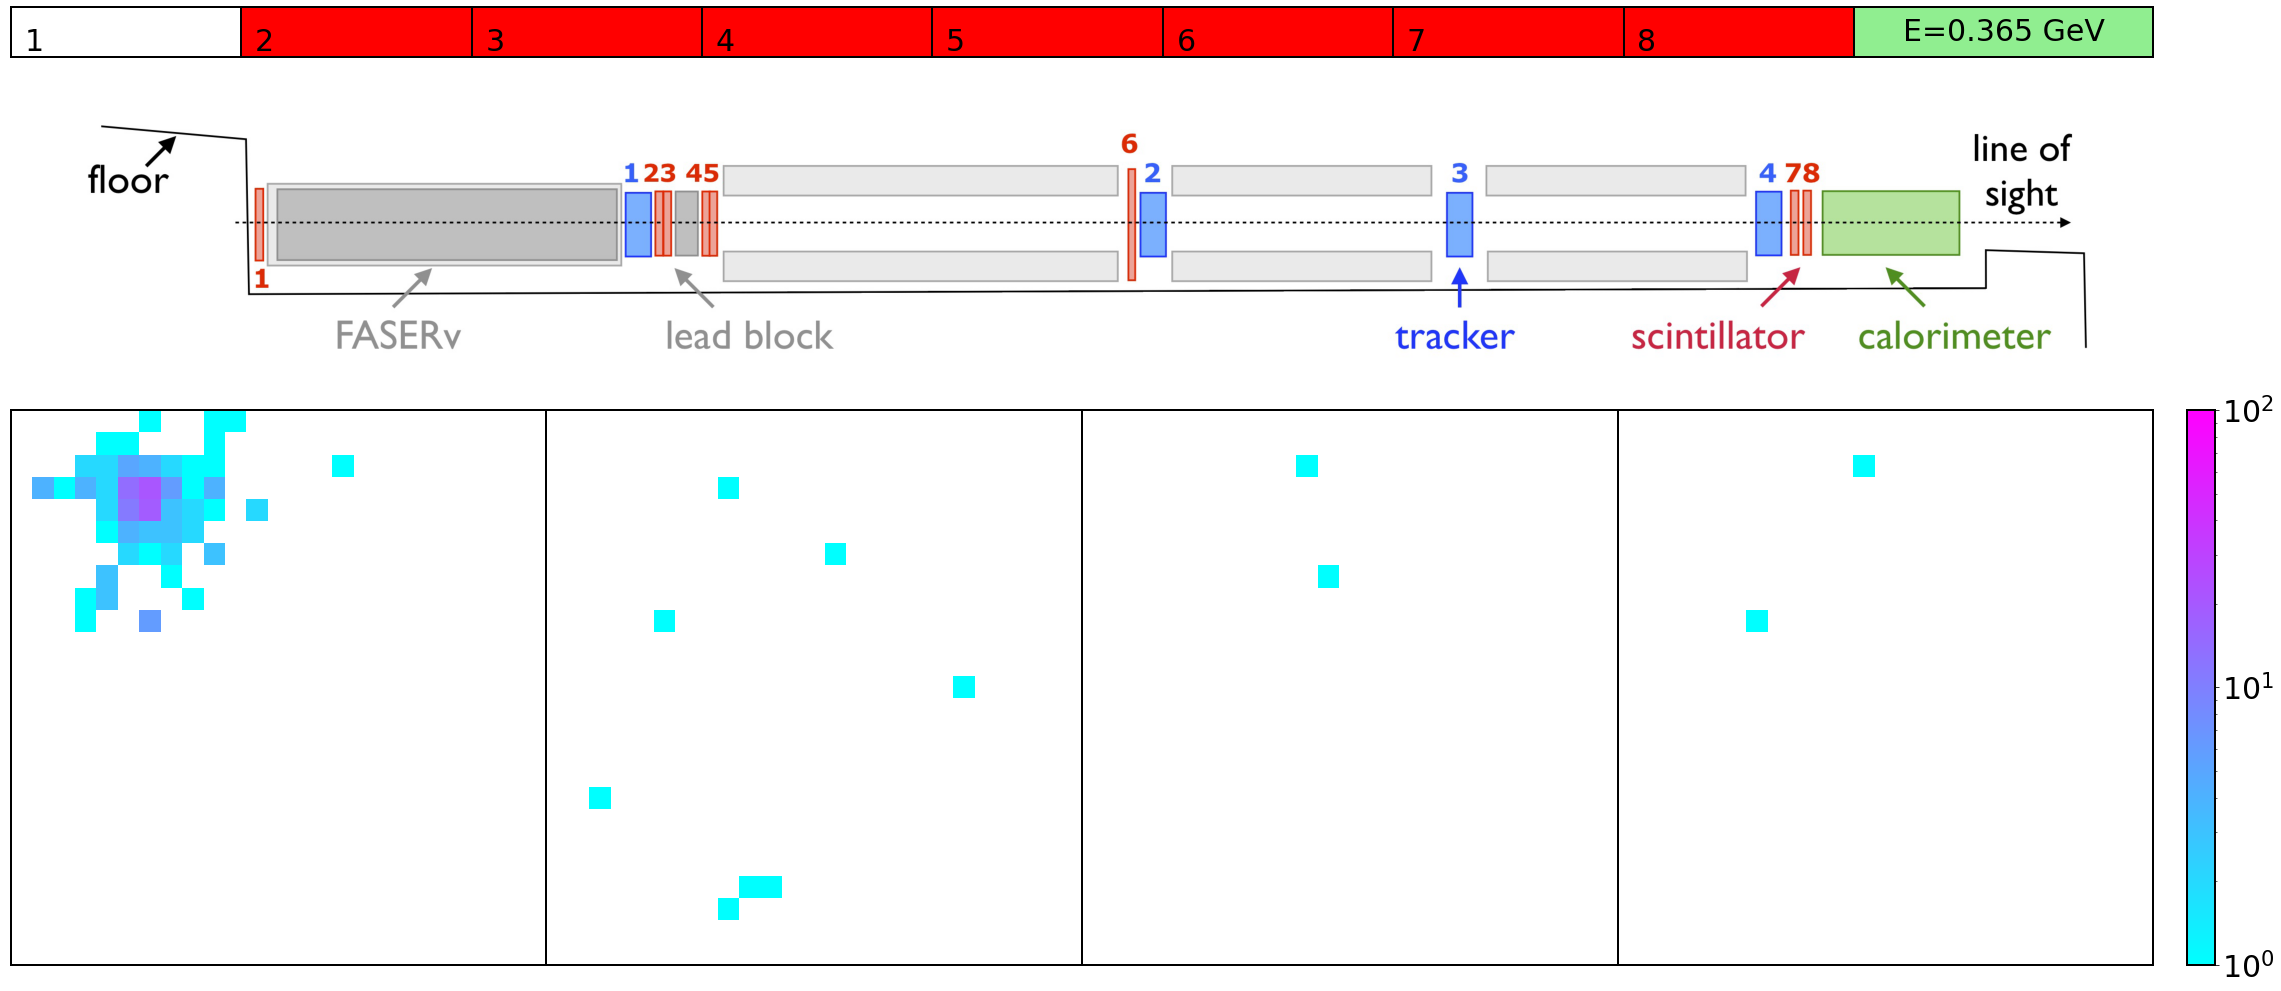

In [5]:
analyser.display_random_event(particle="numu", requirement="(event['scintillator'] == [0, 0, 1, 1, 1, 1, 1, 1, 1, 1]).all()")

## Calorimeter Energy

###  Introduction

At first, we can define some new obseravbles via `Analyser.define_observable()`. It then loops through all events, and stores an additional property. For example here, I add the property `passed_scintillator` which is `True` when the last 7 scintillators and the calorimeter are on, and `False` otherwise. The events now have a property `event['passed_scintillator']` which can be used later on. 

In [6]:
analyser.define_observable(
    name="passed_scintillator", 
    definition="(event['scintillator'][:-1] == [0, 0, 1, 1, 1, 1, 1, 1, 1]).all()"
)

In the next step, let's look at some distribution. This can be done using `Analyser.get_histodata()`, which takes 
- the `particle` (so `muon`, `numu` and `nuel`)
- the `observable` which can be any property of the event which can be called as `event[observable]`
- the `requirement` which specifies the event selection.
- the `bins` which specifies the binning

The function returns the binned data as an array, with the column corresponding to the bin center, the bin value and the uncertainty. 

Below we look at the calorimeter output for all events that have the previously defined scintillator signature. 

In [7]:
bins = np.logspace(-1,3,21)
requirement = "event['passed_scintillator']==True"

data_numu = analyser.get_histodata(particle='numu', observable='calorimeter', bins=bins, requirement=requirement)
data_muon = analyser.get_histodata(particle='muon', observable='calorimeter', bins=bins, requirement=requirement)

This can now be plotted with the `Analyser.plot_histogram()` function.

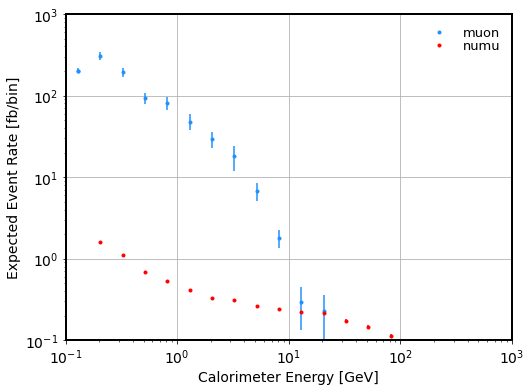

In [8]:
analyser.plot_histogram(
    dataset = [[data_muon, "dodgerblue", "muon"], [data_numu, "red", "numu"], ],
    xlabel = "Calorimeter Energy [GeV]",
    logx = True, logy = True,
    xlim = [1e-1,1e3], ylim = [1e-1,1e3],
    filename = "GeneratedPlots/Fig_ecalo.pdf",
)

### Background Analysis

Let us now dig a bit deeper and try to better understand the calorimeter deposits. At first, we split up the muon sample into different bins of primary muon energy: 

In [9]:
bins = np.logspace(-1,3,21)

data_muon_e1 = analyser.get_histodata(particle='muon', observable='calorimeter', bins=bins, 
    requirement="event['passed_scintillator']==True and event['primaryEnergy']>100  and event['primaryEnergy']<300 ")
data_muon_e2 = analyser.get_histodata(particle='muon', observable='calorimeter', bins=bins, 
    requirement="event['passed_scintillator']==True and event['primaryEnergy']>300  and event['primaryEnergy']<1000")
data_muon_e3 = analyser.get_histodata(particle='muon', observable='calorimeter', bins=bins, 
    requirement="event['passed_scintillator']==True and event['primaryEnergy']>1000 and event['primaryEnergy']<3000")
data_muon_e4 = analyser.get_histodata(particle='muon', observable='calorimeter', bins=bins, 
    requirement="event['passed_scintillator']==True and event['primaryEnergy']>3000 and event['primaryEnergy']<9000")

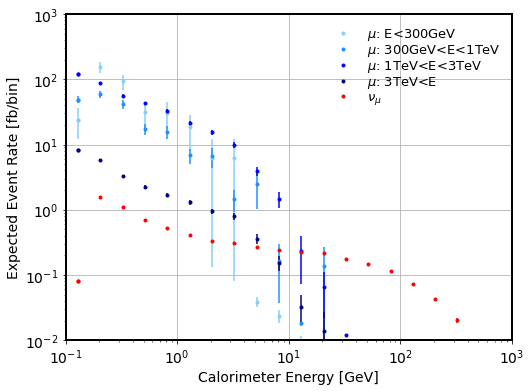

In [10]:
dataset = [
    [data_muon_e1, "lightskyblue" , "$\mu$: E<300GeV"      ],
    [data_muon_e2, "dodgerblue"   , "$\mu$: 300GeV<E<1TeV" ],
    [data_muon_e3, "blue"         , "$\mu$: 1TeV<E<3TeV"   ],
    [data_muon_e4, "navy"         , "$\mu$: 3TeV<E"        ],
    [data_numu   , "red"          , "$\\nu_\mu$"            ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "Calorimeter Energy [GeV]",
    logx = True, logy = True,
    xlim = [1e-1,1e3], ylim = [1e-2,1e3],
    filename = "GeneratedPlots/Fig_ecalo_BG.pdf",
)

### Signal Analysis

Let's now look at the neutrinos. First, let's look at where they interact. Below we show the neutrino rate with / without the scintillator requirement as a function of the position. **Question: Why are there more neutrinos at the end, and not in front? Do you already require the first two scintillators to be off when storing the events?**

In [11]:
bins = np.linspace(0,150,75)
data_numu_z0 = analyser.get_histodata(particle='numu', observable='zposition', bins=bins, 
    requirement="True")
data_numu_z1 = analyser.get_histodata(particle='numu', observable='zposition', bins=bins, 
    requirement="event['passed_scintillator']==True")
data_numu_z2 = analyser.get_histodata(particle='numu', observable='zposition', bins=bins, 
    requirement="event['calorimeter']>1")
data_numu_z3 = analyser.get_histodata(particle='numu', observable='zposition', bins=bins, 
    requirement="event['passed_scintillator']==True and event['calorimeter']>1")

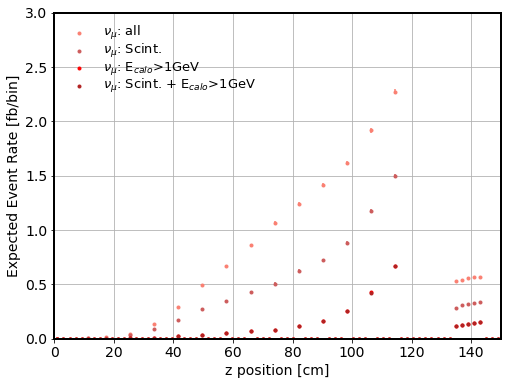

In [12]:
dataset = [
    [data_numu_z0, "salmon"       , "$\\nu_\mu$: all"                       ],
    [data_numu_z1, "indianred"    , "$\\nu_\mu$: Scint. "                   ],
    [data_numu_z2, "red"          , "$\\nu_\mu$: E$_{calo}$>1GeV"           ],
    [data_numu_z3, "firebrick"    , "$\\nu_\mu$: Scint. + E$_{calo}$>1GeV"  ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "z position [cm]",
    logx = False, logy = False,
    xlim = [0,150], ylim = [0,3],
    filename = "GeneratedPlots/Fig_zpos.pdf",
)

Let's also look at the Calorimeter energy distribution, splitted into different positions for the neutrino interaction. We see that mainly the interactions in the end of the tungsten and the lead shield give high energy deposits. 

In [13]:
bins = np.logspace(-1,3,21)

data_numu_e1 = analyser.get_histodata(particle='numu', observable='calorimeter', bins=bins, 
    requirement="event['passed_scintillator']==True and event['zposition']>0  and event['zposition']<60 ")
data_numu_e2 = analyser.get_histodata(particle='numu', observable='calorimeter', bins=bins, 
    requirement="event['passed_scintillator']==True and event['zposition']>60 and event['zposition']<90 ")
data_numu_e3 = analyser.get_histodata(particle='numu', observable='calorimeter', bins=bins, 
    requirement="event['passed_scintillator']==True and event['zposition']>90 and event['zposition']<120")
data_numu_e4 = analyser.get_histodata(particle='numu', observable='calorimeter', bins=bins, 
    requirement="event['passed_scintillator']==True and event['zposition']>120")

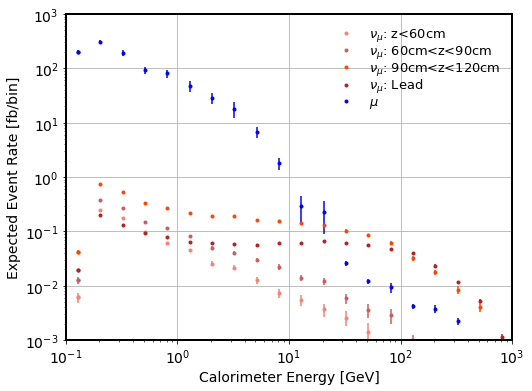

In [14]:
dataset = [
    [data_numu_e1, "salmon"       , "$\\nu_\mu$: z<60cm"      ],
    [data_numu_e2, "indianred"    , "$\\nu_\mu$: 60cm<z<90cm" ],
    [data_numu_e3, "orangered"    , "$\\nu_\mu$: 90cm<z<120cm"],
    [data_numu_e4, "firebrick"    , "$\\nu_\mu$: Lead"        ],
    [data_muon   , "blue"         , "$\mu$"                   ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "Calorimeter Energy [GeV]",
    logx = True, logy = True,
    xlim = [1e-1,1e3], ylim = [1e-3,1e3],
    filename = "GeneratedPlots/Fig_ecalo_Signal.pdf",
)

# Tracker Observables

### New Obseravbles

Let us first define a bunch of tracker obseravbles. For this, let's consider that each layer consists of a set of pixels $i$ with coordinates $(x_i, y_i)$ and a number of tracks $n_i$. We can then define the following observables for each layer
 - track multiplicity: $N = \sum_{i} n_i$

In [15]:
analyser.define_observable(name="ntracks_1", definition="0 if len(event['hits1'])==0 else sum(event['hits1'].T[2])")
analyser.define_observable(name="ntracks_2", definition="0 if len(event['hits2'])==0 else sum(event['hits2'].T[2])")
analyser.define_observable(name="ntracks_3", definition="0 if len(event['hits3'])==0 else sum(event['hits3'].T[2])")
analyser.define_observable(name="ntracks_4", definition="0 if len(event['hits4'])==0 else sum(event['hits4'].T[2])")

 - centrality: if $(X,Y) = 1/N \sum_i n_i \times (x_i,y_i)$, then the centrality is $C = \text{max}( |X|, |Y|)$. This measure of centrality corresponds to the distance to the nearest edge. 

In [16]:
for ilayer in ["1","2","3","4"]:
    #define function
    def calculate_centrality(event):
        if len(event['hits'+ilayer])==0: return -1
        pos = sum(np.array([n*x,n*y]) for x,y,n in event['hits'+ilayer]) / sum(event['hits'+ilayer].T[2])
        return max(abs(pos[0]),abs(pos[1]))
    #calculate observable
    analyser.define_observable_from_function(name="centrality_"+ilayer, function=calculate_centrality)

- spread: if $(X,Y) = 1/N \sum_i n_i \times (x_i,y_i)$ is the central point, then the spread is $S^2 = 1/N \sum_i n_i \times [(x_i,_yi)-(X,Y)]^2$. So this us the standard deviation from the center of the track distribution. 

In [17]:
for ilayer in ["1","2","3","4"]:
    #define function
    def calculate_spread(event):
        if len(event['hits'+ilayer])==0: return -1
        pos = sum(np.array([n*x,n*y]) for x,y,n in event['hits'+ilayer]) / sum(event['hits'+ilayer].T[2])
        s2 = sum(n*(x-pos[0])**2+n*(y-pos[1])**2 for x,y,n in event['hits'+ilayer]) 
        return np.sqrt(s2/sum(event['hits'+ilayer].T[2]))
    #calculate observable
    analyser.define_observable_from_function(name="spread_"+ilayer, function=calculate_spread)

### Multiplicities

Let's start by looking at the multiplicities. Let's focus on the first tracking station, which is the most interesting one. We can see that we have an excess of neutrino events with high track multiplicities. The scintillator cut certainly helps to reduce background. 

In [18]:
bins = np.logspace(0,3,16)
data_numu_n1 = analyser.get_histodata(particle='numu', observable='ntracks_1', bins=bins, 
    requirement="event['passed_scintillator']==True")
data_muon_n1 = analyser.get_histodata(particle='muon', observable='ntracks_1', bins=bins, 
    requirement="event['passed_scintillator']==True")

data_numu_nocut_n1 = analyser.get_histodata(particle='numu', observable='ntracks_1', bins=bins, 
    requirement="True")
data_muon_nocut_n1 = analyser.get_histodata(particle='muon', observable='ntracks_1', bins=bins, 
    requirement="True")

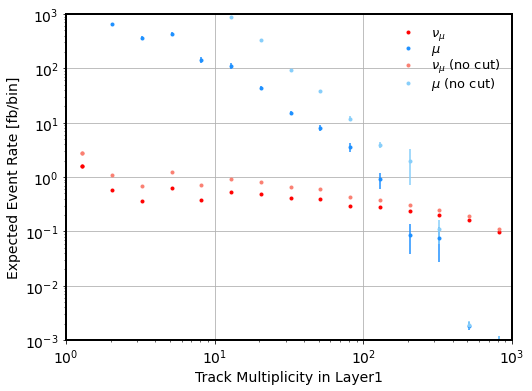

In [19]:
dataset = [
    [data_numu_n1      , "red"          , "$\\nu_\mu$"         ],
    [data_muon_n1      , "dodgerblue"   , "$\mu$"              ],
    [data_numu_nocut_n1, "salmon"       , "$\\nu_\mu$ (no cut)"],
    [data_muon_nocut_n1, "lightskyblue" , "$\mu$ (no cut)"     ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "Track Multiplicity in Layer1",
    logx = True, logy = True,  xlim = [1,1000], ylim = [1e-3,1e3],
    filename = "GeneratedPlots/Fig_ntrack_1.pdf",
)

As before, let's split up the signal into different interaction positions. As expected, the majority of the signal comes from the end of the tungsten. 

In [20]:
bins = np.logspace(0,3,16)

data_numu_n11 = analyser.get_histodata(particle='numu', observable='ntracks_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['zposition']>0  and event['zposition']<60 ")
data_numu_n12 = analyser.get_histodata(particle='numu', observable='ntracks_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['zposition']>60 and event['zposition']<90 ")
data_numu_n13 = analyser.get_histodata(particle='numu', observable='ntracks_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['zposition']>90 and event['zposition']<120")
data_numu_n14 = analyser.get_histodata(particle='numu', observable='ntracks_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['zposition']>120")

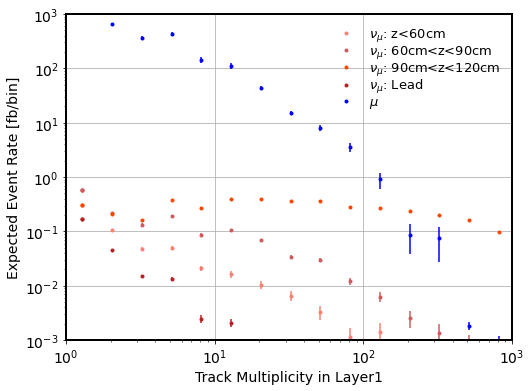

In [21]:
dataset = [
    [data_numu_n11, "salmon"       , "$\\nu_\mu$: z<60cm"      ],
    [data_numu_n12, "indianred"    , "$\\nu_\mu$: 60cm<z<90cm" ],
    [data_numu_n13, "orangered"    , "$\\nu_\mu$: 90cm<z<120cm"],
    [data_numu_n14, "firebrick"    , "$\\nu_\mu$: Lead"        ],
    [data_muon_n1 , "blue"         , "$\mu$"                   ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "Track Multiplicity in Layer1",
    logx = True, logy = True,
    xlim = [1,1e3], ylim = [1e-3,1e3],
    filename = "GeneratedPlots/Fig_ntrack1_Signal.pdf",
)

### Centrality

Let's now look at the centrality measures. We focus on the first two layers, the others are less interesting. However, we note that there is no big difference. 

In [22]:
bins = np.linspace(0,13,14)
data_numu_cc1 = analyser.get_histodata(particle='numu', observable='centrality_1', bins=bins, 
    requirement="event['passed_scintillator']==True")
data_muon_cc1 = analyser.get_histodata(particle='muon', observable='centrality_1', bins=bins, 
    requirement="event['passed_scintillator']==True")
data_numu_cc2 = analyser.get_histodata(particle='numu', observable='centrality_2', bins=bins, 
    requirement="event['passed_scintillator']==True")
data_muon_cc2 = analyser.get_histodata(particle='muon', observable='centrality_2', bins=bins, 
    requirement="event['passed_scintillator']==True")

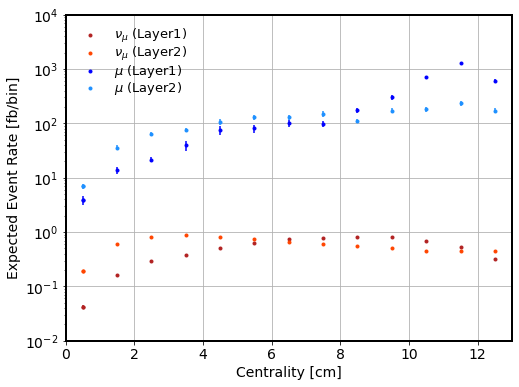

In [23]:
dataset = [
    [data_numu_cc1, "firebrick"    , "$\\nu_\mu$ (Layer1)" ],
    [data_numu_cc2, "orangered"    , "$\\nu_\mu$ (Layer2)" ],
    [data_muon_cc1, "blue"         , "$\mu$ (Layer1)"      ],
    [data_muon_cc2, "dodgerblue"   , "$\mu$ (Layer2)"      ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "Centrality [cm]",
    logx = False, logy = True,  xlim = [0,13], ylim = [1e-2,1e4],
    filename = "GeneratedPlots/Fig_centrality.pdf",
)

To suppress backgrounds, let us look at the centrality distribution for various different bins of track multiplicities. It's hard to say if the centrality helps at high multiplicities. Maybe it helps a bit in the context of a multi-variet analysis.  

In [24]:
bins = np.linspace(0,10,21)
data_numu_c11 = analyser.get_histodata(particle='numu', observable='centrality_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>10 and event['ntracks_1']<30")
data_muon_c11 = analyser.get_histodata(particle='muon', observable='centrality_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>10 and event['ntracks_1']<30")
data_numu_c12 = analyser.get_histodata(particle='numu', observable='centrality_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>30 and event['ntracks_1']<100")
data_muon_c12 = analyser.get_histodata(particle='muon', observable='centrality_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>30 and event['ntracks_1']<100")
data_numu_c13 = analyser.get_histodata(particle='numu', observable='centrality_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>100")
data_muon_c13 = analyser.get_histodata(particle='muon', observable='centrality_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>100")

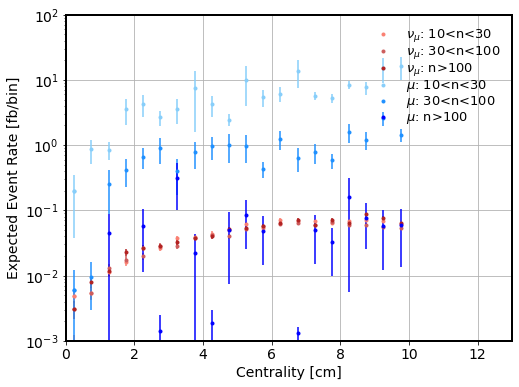

In [25]:
dataset = [
    [data_numu_c11, "salmon"      , "$\\nu_\mu$: 10<n<30"  ],
    [data_numu_c12, "indianred"   , "$\\nu_\mu$: 30<n<100" ],
    [data_numu_c13, "firebrick"   , "$\\nu_\mu$: n>100"    ],
    [data_muon_c11, "lightskyblue", "$\mu$: 10<n<30"       ],
    [data_muon_c12, "dodgerblue"  , "$\mu$: 30<n<100"      ],
    [data_muon_c13, "blue"        , "$\mu$: n>100"         ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "Centrality [cm]",
    logx = False, logy = True,  xlim = [0,13], ylim = [1e-3,1e2],
    filename = "GeneratedPlots/Fig_centrality_ntrack.pdf",
)

### Spread

Let's now look at the spread. We can see that, in the first layer, the signal is more concentrated at low spreads. In the second layer (and also the third and fourth) the spread is bigger. Overall, the background is much larger. 

In [26]:
bins = np.linspace(0,15,31)
data_numu_s1 = analyser.get_histodata(particle='numu', observable='spread_1', bins=bins, 
    requirement="event['passed_scintillator']==True")
data_muon_s1 = analyser.get_histodata(particle='muon', observable='spread_1', bins=bins, 
    requirement="event['passed_scintillator']==True")
data_numu_s2 = analyser.get_histodata(particle='numu', observable='spread_2', bins=bins, 
    requirement="event['passed_scintillator']==True")
data_muon_s2 = analyser.get_histodata(particle='muon', observable='spread_2', bins=bins, 
    requirement="event['passed_scintillator']==True")

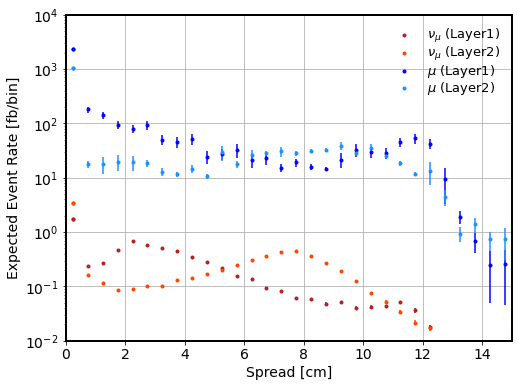

In [27]:
dataset = [
    [data_numu_s1, "firebrick"    , "$\\nu_\mu$ (Layer1)" ],
    [data_numu_s2, "orangered"    , "$\\nu_\mu$ (Layer2)" ],
    [data_muon_s1, "blue"         , "$\mu$ (Layer1)"      ],
    [data_muon_s2, "dodgerblue"   , "$\mu$ (Layer2)"      ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "Spread [cm]",
    logx = False, logy = True,  xlim = [0,15], ylim = [1e-2,1e4],
    filename = "GeneratedPlots/Fig_centrality.pdf",
)

To suppress backgrounds, let us look at the spread distribution for various different bins of track multiplicities. We can see that at the high-multiplicity bins, the spread can help to further single out the signal.  

In [28]:
bins = np.linspace(0,15,31)
data_numu_s11 = analyser.get_histodata(particle='numu', observable='spread_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>10 and event['ntracks_1']<30")
data_muon_s11 = analyser.get_histodata(particle='muon', observable='spread_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>10 and event['ntracks_1']<30")
data_numu_s12 = analyser.get_histodata(particle='numu', observable='spread_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>30 and event['ntracks_1']<100" )
data_muon_s12 = analyser.get_histodata(particle='muon', observable='spread_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>30 and event['ntracks_1']<100")
data_numu_s13 = analyser.get_histodata(particle='numu', observable='spread_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>100")
data_muon_s13 = analyser.get_histodata(particle='muon', observable='spread_1', bins=bins, 
    requirement="event['passed_scintillator']==True and event['ntracks_1']>100")

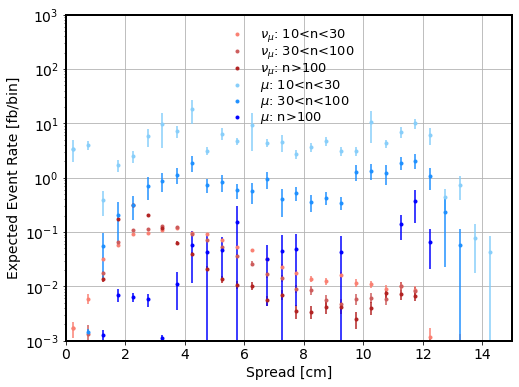

In [29]:
dataset = [
    [data_numu_s11, "salmon"      , "$\\nu_\mu$: 10<n<30"  ],
    [data_numu_s12, "indianred"   , "$\\nu_\mu$: 30<n<100" ],
    [data_numu_s13, "firebrick"   , "$\\nu_\mu$: n>100"    ],
    [data_muon_s11, "lightskyblue", "$\mu$: 10<n<30"       ],
    [data_muon_s12, "dodgerblue"  , "$\mu$: 30<n<100"      ],
    [data_muon_s13, "blue"        , "$\mu$: n>100"         ],
]

analyser.plot_histogram(
    dataset = dataset,
    xlabel = "Spread [cm]",
    logx = False, logy = True,  xlim = [0,15], ylim = [1e-3,1e3],
    filename = "GeneratedPlots/Fig_spread_ntrack.pdf",
)

## 2D Distributions

In [30]:
def plot_2dhistogram_primary(observable, bins, requirement=None,
        label="Observable", log=False, filename=None ):
    
    # check if data exists: 
    if len(analyser.numu_data)==0: print ("Error: no numu signal data")
    if len(analyser.muon_data)==0: print ("Error: no muon background data")
    
    # prepare plot
    matplotlib.rcParams.update({'font.size': 14})
    fig = plt.figure(figsize=(8*2,6))
    bins_b = np.linspace(0,3600,18+1)
    bins_s = np.logspace(1,4,30+1)
    
    # loop through events
    selected_data_s, selected_data_b = [], []
    for event in analyser.numu_data:
        if eval(requirement) == False: continue
        selected_data_s.append([event['primaryEnergy'], event[observable], event['weight']])
    for event in analyser.muon_data:
        if eval(requirement) == False: continue
        selected_data_b.append([event['primaryEnergy'], event[observable], event['weight']])
    selected_data_s = np.array(selected_data_s)
    selected_data_b = np.array(selected_data_b)
        
    # plot signal data
    ax = plt.subplot(1,2,1)
    hs = ax.hist2d(
        selected_data_s.T[0], selected_data_s.T[1], weights=selected_data_s.T[2],
        bins=[bins_s,bins], range=[[bins_s[0], bins_s[-1]],[bins[0], bins[-1]]],
        norm=matplotlib.colors.LogNorm(),cmap='jet',
    )
    plt.colorbar(hs[3])
    ax.set_title("Muon Neutrino [fb/bin")
    ax.set_xlabel('Neutrino Energy [GeV]')
    ax.set_ylabel(label)  
    ax.set_xscale("log")
    if log: ax.set_yscale("log")
    
    ax = plt.subplot(1,2,2)
    hb = ax.hist2d(
        selected_data_b.T[0], selected_data_b.T[1], weights=selected_data_b.T[2],
        bins=[bins_b,bins], range=[[bins_b[0], bins_b[-1]],[bins[0], bins[-1]]],
        norm=matplotlib.colors.LogNorm(),cmap='jet',
    )
    plt.colorbar(hb[3])
    ax.set_title("Muons [fb/bin]")
    ax.set_xlabel('Muon Energy [GeV]')
    ax.set_ylabel(label)  
    if log: ax.set_yscale("log")    
        
    if filename is not None: fig.savefig(filename)
    plt.show()

Let's first define the bins for all considered observables:

In [31]:
observable_bins={
    'ntracks'         : np.logspace(0,3,15+1)   , 
    'calorimeter'     : np.logspace(-2,3,25+1)  , 
    'primaryEnergy'   : np.linspace(0,3600,18+1), 
    'centrality'      : np.linspace(0,13,13+1), 
    'spread'          : np.linspace(0,15,30+1), 
}

Let's now look at a variety of correlations:

### Incoming Muon Energy
-  calorimeter energy vs muon energy

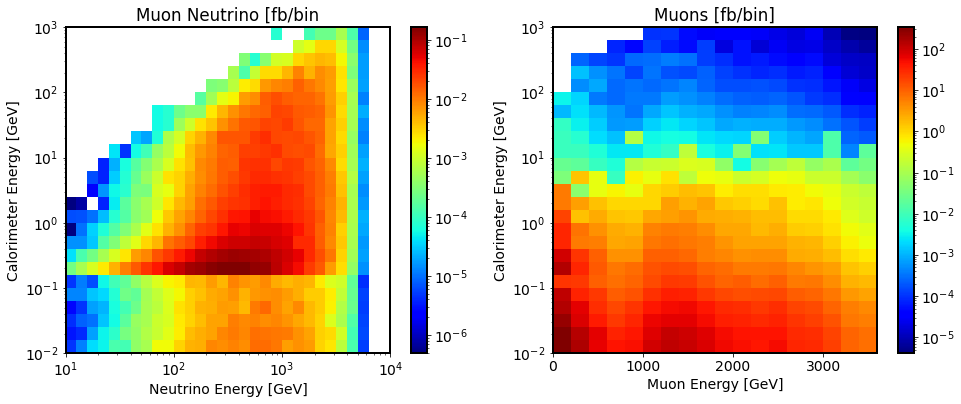

In [32]:
plot_2dhistogram_primary(
    observable="calorimeter", 
    bins=observable_bins['calorimeter'],
    label="Calorimeter Energy [GeV]",
    log = True,
    requirement="event['passed_scintillator']==True", 
)

-  track multiplicity in layer 1 vs muon energy

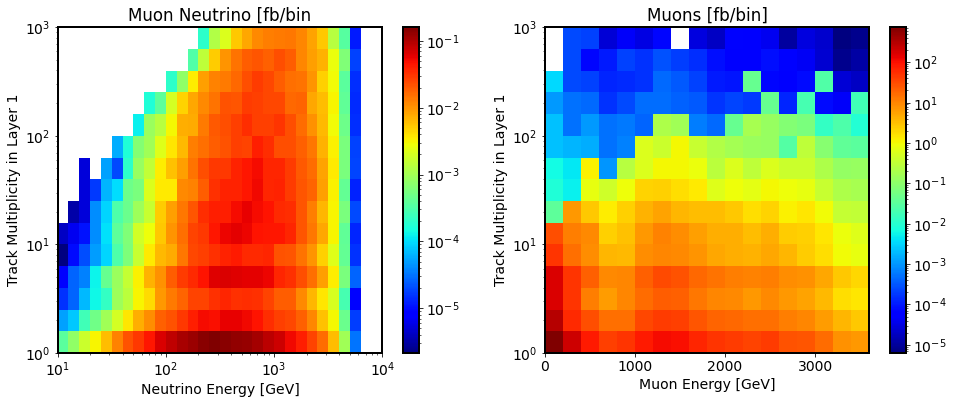

In [33]:
plot_2dhistogram_primary(
    observable="ntracks_1", 
    bins=observable_bins['ntracks'],
    label="Track Multiplicity in Layer 1",
    log = True,
    requirement="event['passed_scintillator']==True", 
)

-  centrality in layer 1 vs muon energy

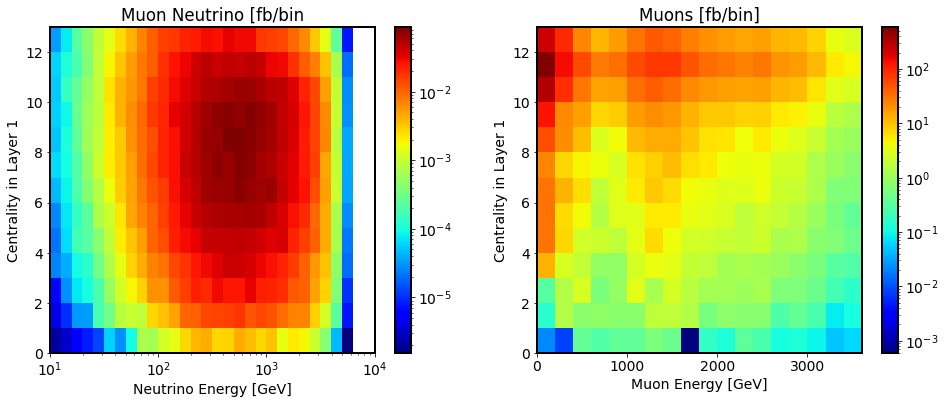

In [34]:
plot_2dhistogram_primary(
    observable="centrality_1", 
    bins=observable_bins['centrality'],
    label="Centrality in Layer 1",
    log = False,
    requirement="event['passed_scintillator']==True", 
)

-  spread n layer 1 vs muon energy

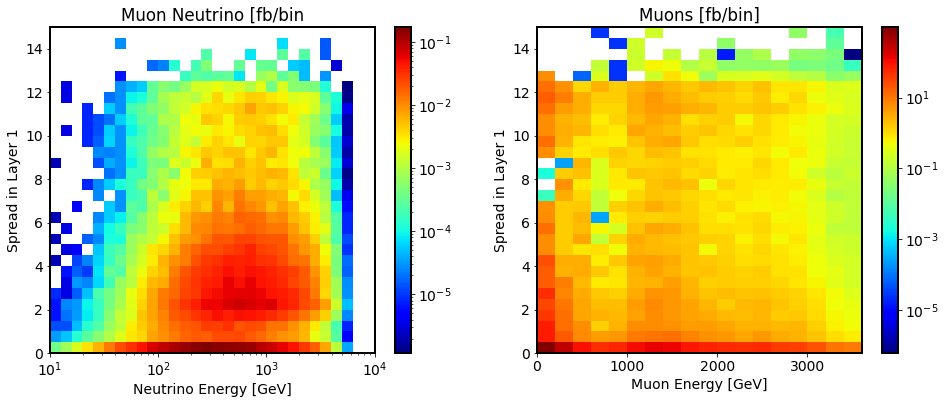

In [35]:
plot_2dhistogram_primary(
    observable="spread_1", 
    bins=observable_bins['spread'],
    label="Spread in Layer 1",
    log = False,
    requirement="event['passed_scintillator']==True", 
)

### Tracker Observables vs Calorimeter Energy 

- number of tracks in 1st layer vs calorimeter energy

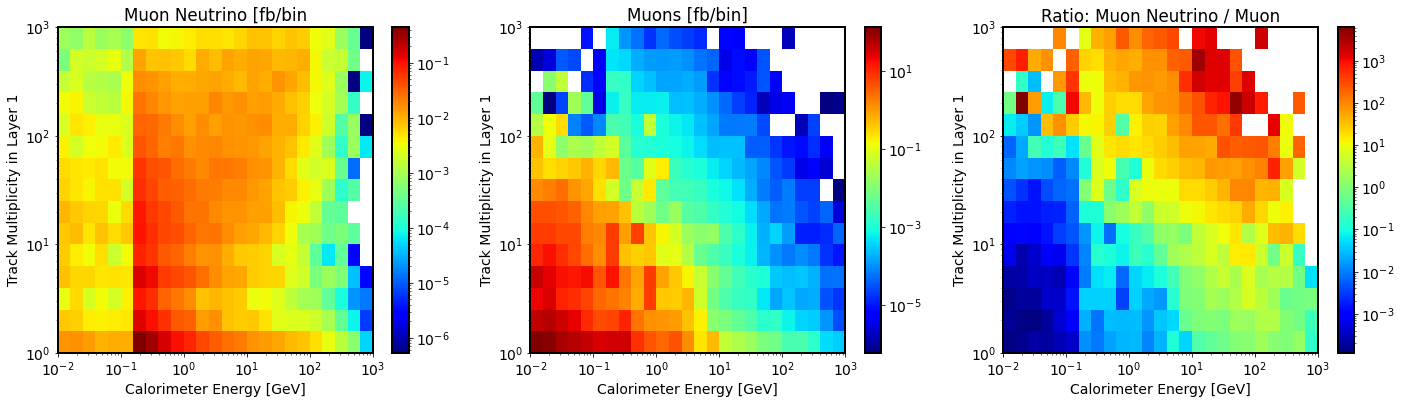

In [36]:
analyser.plot_2dhistogram(
    observable1='calorimeter', 
    bins1=observable_bins['calorimeter'],
    xlabel="Calorimeter Energy [GeV]",
    logx = True,
    observable2="ntracks_1", 
    bins2=observable_bins['ntracks'],
    ylabel="Track Multiplicity in Layer 1",
    logy = True,
    requirement="event['passed_scintillator']==True", 
)

- centrality in 1st layer vs calorimeter energy

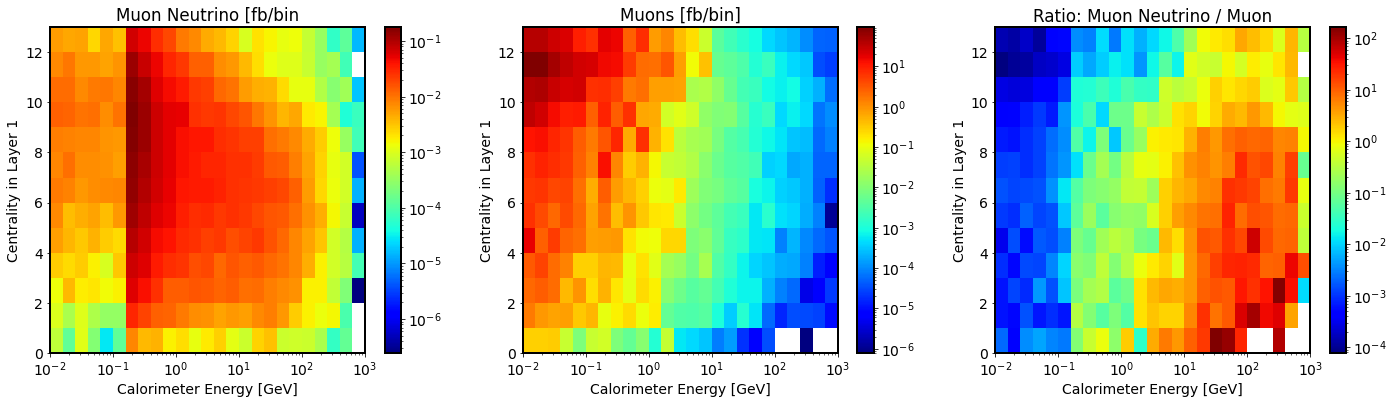

In [37]:
analyser.plot_2dhistogram(
    observable1='calorimeter', 
    bins1=observable_bins['calorimeter'],
    xlabel="Calorimeter Energy [GeV]",
    logx = True,
    observable2="centrality_1", 
    bins2=observable_bins['centrality'],
    ylabel="Centrality in Layer 1",
    logy = False,
    requirement="event['passed_scintillator']==True", 
)

- spread in 1st layer vs calorimeter energy

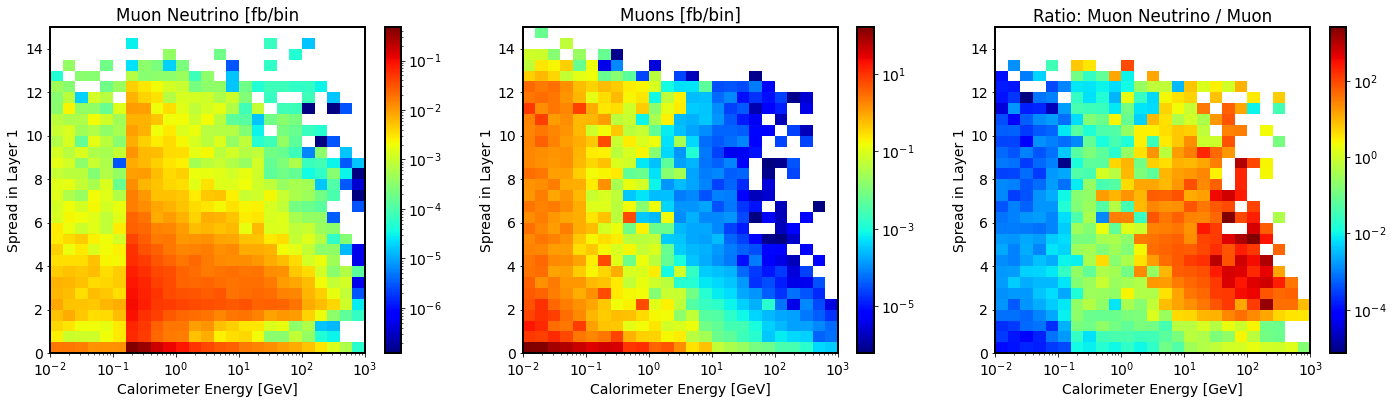

In [38]:
analyser.plot_2dhistogram(
    observable1='calorimeter', 
    bins1=observable_bins['calorimeter'],
    xlabel="Calorimeter Energy [GeV]",
    logx = True,
    observable2="spread_1", 
    bins2=observable_bins['spread'],
    ylabel="Spread in Layer 1",
    logy = False,
    requirement="event['passed_scintillator']==True", 
)

### Tracker Observables

- centrality in 1st layer vs number of tracks in 1st layer

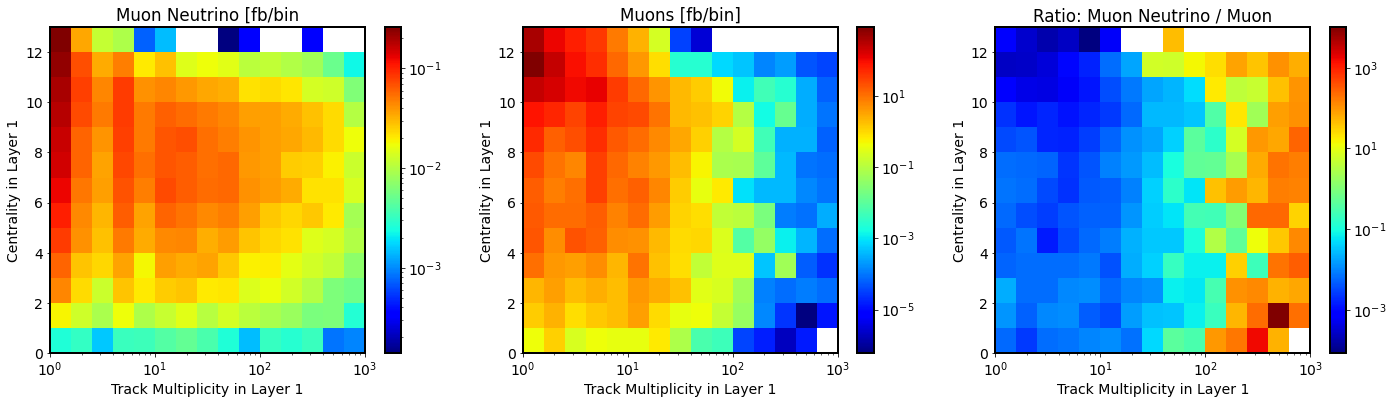

In [39]:
analyser.plot_2dhistogram(
    observable1="ntracks_1", 
    bins1=observable_bins['ntracks'],
    xlabel="Track Multiplicity in Layer 1",
    logx = True,
    observable2="centrality_1", 
    bins2=observable_bins['centrality'],
    ylabel="Centrality in Layer 1",
    logy = False,
    requirement="event['passed_scintillator']==True", 
)

- spread in 1st layer vs number of tracks in 1st layer

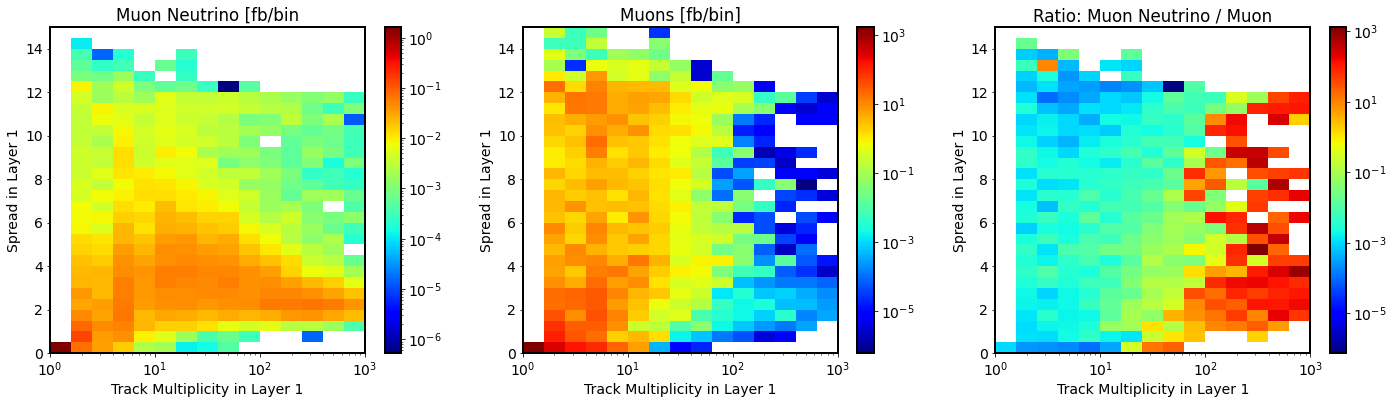

In [40]:
analyser.plot_2dhistogram(
    observable1="ntracks_1", 
    bins1=observable_bins['ntracks'],
    xlabel="Track Multiplicity in Layer 1",
    logx = True,
    observable2="spread_1", 
    bins2=observable_bins['spread'],
    ylabel="Spread in Layer 1",
    logy = False,
    requirement="event['passed_scintillator']==True", 
)

- spread in 1st layer vs centrality in 1st layer

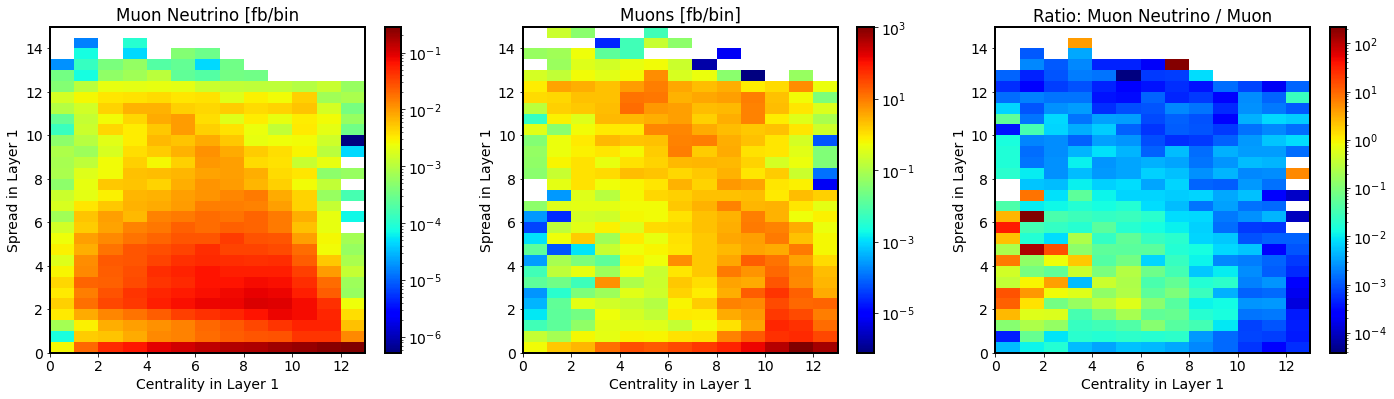

In [41]:
analyser.plot_2dhistogram(
    observable1="centrality_1", 
    bins1=observable_bins['centrality'],
    xlabel="Centrality in Layer 1",
    logx = False,
    observable2="spread_1", 
    bins2=observable_bins['spread'],
    ylabel="Spread in Layer 1",
    logy = False,
    requirement="event['passed_scintillator']==True", 
)

# Determining the significance of an observation

Felix suggested that I follow the paper https://arxiv.org/pdf/1007.1727.pdf. I do not quite understand their methods. In particular, it isn't clear to me what $t_{\mu, \mathrm{obs}}$ is nor what $f(t_\mu | \mu)$ are or how determine them in our scenarios. Instead, I will perform a Bayesian analysis since that makes more sense to me.

### The Bayesian Problem

Our probabilistic model is the Poisson probability distribution
$$ \mathrm{Poisson}(x | s + b) = \frac{(s+b)^x e^{-(s+b)}}{x!} $$
which determines the probability to measure $x$ events given the expectation that there will be $s$ signal events and $b$ background events. In our case, we have a model (the simulation) which predicts the values of $s$ and $b$ to a given certainty. This information can be used to form a Gaussian prior on $s$ and $b$
$$ \mathrm{Gaussian}(s | \theta_s ) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left (-\frac{(s-\hat s)^2}{2\sigma^2} \right ) $$
where $\theta_s$ represents our model and $\hat s$ and $\sigma$ are the mean and standard deviation from our model. One can write identical formula for the background model $\theta_b$.

Then the posterior probability to observe $x$ events is
$$ P(x | \theta_s, \theta_b ) = \int_0^\infty \mathrm{Poisson(x | s + b)} \mathrm{Gaussian} ( s | \theta_s ) \mathrm{Gaussian} ( b | \theta_b ) ds db. $$

The probability that the entire measurement is background is then the $p$-value corresponding to the observation of $x$ events is
$$ p(x) = P(X \geq x | s=0) = \sum_{n=x}^\infty \int_0^\infty \mathrm{Poisson}(n | 0 + b) \mathrm{Gaussian}(b | \theta_b) db. $$

The more relevant quantity in the Bayesian approach is the Bayes factor, the probability ratio that the data $x$ favors the null hypothesis to the alternate hypothesis
$$ BF(x) = \frac{P(x | s=0)}{\int_0^\infty P(x | s , \theta_b) \pi(s | \theta_s) ds}. $$

Another issue we must address is that we do not have data, i.e. $x$ has not been measured. We will instead ask for the expectation value of these quantities ($p$-value and Bayes factor) given a Poisson distribution on $x$ as determined by the model.

The method `count_events(particle, requirement)` will return the weighted count and uncertainty of the events meeting `requirement` in the `particle` dataset of the Analyzer. The `calculate_stats(requirement, LHCscale)` method uses the `count_events` method to determine the signal and background counts meeting `requirement` and uses that data to calculate the above statistical quantities given the expected data for the LHC luminosity `LHCscale`. The method returns a dictionary with the following keys
- `signal` : tuple with the signal counts and uncertainty
- `background` : tuple with the background counts and uncertainty
- `x-values` : observation values considered for `x` (should cover all non-negligible values)
- `p-values` : calculated p-values for each x value in `x-values`
- `Bayes Factors` : calculated Bayes factors for each x value in `x-values`
- `p-expected` : expectation value of `p-value` (sum of `p-values` convoluted with the poisson distribution)
- `BF-expected` : expectation value of `Bayes Factors` (sum of `Bayes Factors` convoluted with the poisson distribution)

In [42]:
stats_analysis = analyser.calculate_stats(requirement="event['passed_scintillator'] and event['calorimeter'] > 1")

In [43]:
stats_analysis['nsignal'][0]

3.162534167175166

In [44]:
stats_analysis['nbackground'][0]

104.32746784790167

In [45]:
for x,p in zip(stats_analysis['x-values'], stats_analysis['p-values']): 
    print (x,p)

0 1.0000000000000528
1 1.0000000000000528
2 1.0000000000000528
3 1.0000000000000528
4 1.0000000000000528
5 1.0000000000000528
6 1.0000000000000528
7 1.0000000000000528
8 1.0000000000000528
9 1.0000000000000528
10 1.0000000000000528
11 1.0000000000000528
12 1.0000000000000528
13 1.0000000000000528
14 1.0000000000000528
15 1.0000000000000528
16 1.0000000000000528
17 1.0000000000000528
18 1.0000000000000528
19 1.0000000000000528
20 1.0000000000000528
21 1.0000000000000528
22 1.0000000000000528
23 1.0000000000000528
24 1.0000000000000528
25 1.0000000000000528
26 1.0000000000000528
27 1.0000000000000528
28 1.0000000000000528
29 1.0000000000000528
30 1.0000000000000528
31 1.0000000000000528
32 1.0000000000000528
33 1.0000000000000528
34 1.0000000000000526
35 1.000000000000052
36 1.0000000000000497
37 1.0000000000000437
38 1.0000000000000266
39 0.99999999999998
40 0.9999999999998546
41 0.9999999999995268
42 0.999999999998693
43 0.9999999999966218
44 0.9999999999915965
45 0.9999999999796814
46

### Felix Statistics

In [46]:
from scipy.stats import chi2
from scipy import special
from scipy.special import entr, logsumexp, betaln, gammaln as gamln, zeta

def calculate_stats_felix(requirement="True", luminosity = 1, do_plot=True):
      
    # for some reason, poisson.logpmf(k, mu) requires k to be an integer
    # here I implement it in a way that also works for floats
    def mylogpmf(k,mu):
        return special.xlogy(k, mu) - gamln(k + 1) - mu
    
    # claculated -2*log_r 
    def m2logr(ns, nb, mu=1):
        log_pois_sb = mylogpmf(k=ns+nb, mu=mu*ns+nb)
        log_pois_b  = mylogpmf(k=ns+nb, mu=ns+nb   )
        log_r_rate  = log_pois_sb - log_pois_b
        return -2*log_r_rate

    # get signal and background rate
    muon_mean, muon_err = analyser.count_events(particle='muon', requirement=requirement)
    numu_mean, numu_err = analyser.count_events(particle='numu', requirement=requirement)
    nuel_mean, nuel_err = analyser.count_events(particle='nuel', requirement=requirement)

    bkg_mean, bkg_err = muon_mean, muon_err
    sig_mean, sig_err = numu_mean + nuel_mean, np.sqrt(numu_err**2+nuel_err**2)
        
    # multiply luminosity
    sig_mean, sig_err = sig_mean*luminosity, sig_err*luminosity
    bkg_mean, bkg_err = bkg_mean*luminosity, bkg_err*luminosity
    
    # get logr and p values
    mus = np.linspace(0,3,91)
    m2logrs = [m2logr(sig_mean, bkg_mean, mu=mu) for mu in mus]
    pvals = [chi2.sf(m2logr, df=1) for m2logr in m2logrs]
    
    m2logrs_p = [m2logr(sig_mean, bkg_mean+bkg_err, mu=mu) for mu in mus]
    pvals_p = [chi2.sf(m2logr, df=1) for m2logr in m2logrs_p]
    
    m2logrs_m = [m2logr(sig_mean, bkg_mean-bkg_err, mu=mu) for mu in mus]
    pvals_m = [chi2.sf(m2logr, df=1) for m2logr in m2logrs_m]
        
    # plot signaficance vs signal strength
    if do_plot:
        print ("Nsignal:", sig_mean)
        print ("Nbackground:", bkg_mean)
        print ("Expected Pvalue for Discovery:", pvals[0])
        
        matplotlib.rcParams.update({'font.size': 14})
        fig = plt.figure(figsize=(8*2,6))

        ax = plt.subplot(1,2,1)
        ax.plot(mus,m2logrs  , lw=2, c="red")
        ax.plot(mus,m2logrs_p, lw=1, c="red")
        ax.plot(mus,m2logrs_m, lw=1, c="red")
        ax.set_xlabel("Signal Strength $\mu$")
        ax.set_ylabel("-2 E[log_r($\mu=\mu$, $\mu=0$)| $\mu$]")
        ax.set_ylim(0,12)
        for delta in [1,4,9]: ax.plot([mus[0],mus[-1]],[delta,delta],linestyle="dashed",color="k")
        ax.grid()

        ax = plt.subplot(1,2,2)
        ax.plot(mus,pvals  , lw=2, c="red")
        ax.plot(mus,pvals_p, lw=1, c="red")
        ax.plot(mus,pvals_m, lw=1, c="red")
        ax.set_xlabel("Signal Strength $\mu$")
        ax.set_ylabel("p-value")
        ax.set_yscale("log")
        ax.set_ylim(1e-3,1)
        for delta in [1-.6827,1-.9545,1-0.9973]: ax.plot([mus[0],mus[-1]],[delta,delta],linestyle="dashed",color="k")
        ax.grid()
        
        plt.show()
    
    # summarize results
    analysis = {}
    analysis['nsignal']     = (sig_mean, sig_err)
    analysis['nbackground'] = (bkg_mean, bkg_err)
    analysis['mu-values'] = mus
    analysis['r-values'] = -0.5*np.array(m2logrs)
    analysis['p-values'] = pvals
    analysis['p-value_discovery'] = pvals[0]  
    analysis['significance_discovery'] = np.sqrt(m2logrs[0]) 
        
    # return p_value
    return analysis

Nsignal: 15.812670835875831
Nbackground: 521.6373392395084
Expected Pvalue for Discovery: 0.49089380905420743


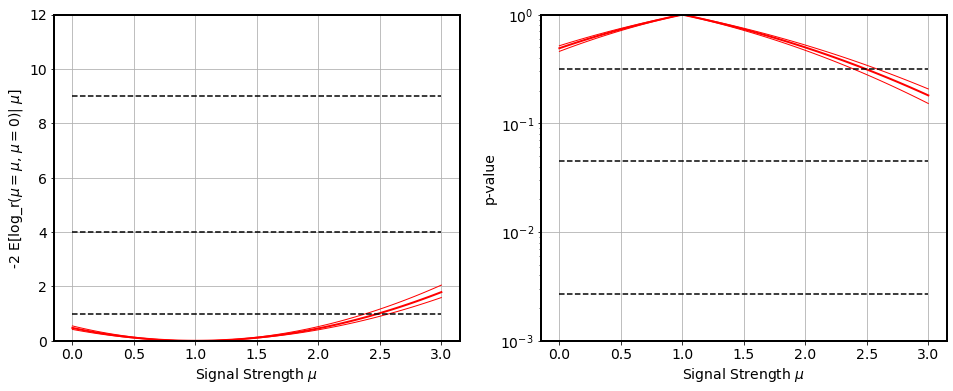

In [47]:
requirement="event['passed_scintillator'] and event['calorimeter'] > 1"
analysis = calculate_stats_felix(requirement=requirement, luminosity= 5)

In [48]:
def mylogpmf(k,mu):
    return special.xlogy(k, mu) - gamln(k + 1) - mu
def m2logr(ns, nb, mu=1):
    log_pois_sb = mylogpmf(k=ns+nb, mu=mu*ns+nb)
    log_pois_b  = mylogpmf(k=ns+nb, mu=ns+nb   )
    log_r_rate  = log_pois_sb - log_pois_b
    print (np.sqrt(-2*log_r_rate))
    return -2*log_r_rate
def pvalue(ns,nb,mu=1):
    return chi2.sf(m2logr(ns,nb,mu), df=1)

pvalue(93.5, 1.37, mu=0)

24.84070428975346


3.2588970398640997e-136

Define some benchmark luminosities (5 fb$^-1$ is what we can collect in the first few weeks, 150 fb$^-1$ is the full LHC Run 3 Luminosity)

In [49]:
lumis = [5,20,50,150]

- only calorimeter cuts

In [50]:
print("      Emin       Lumi         NS         NB   Significance") 
for ecut in [5,10,15]:
    for lumi in lumis:
        requirement="event['passed_scintillator'] and event['calorimeter']>"+str(ecut)
        ana = calculate_stats_felix(requirement=requirement, luminosity=lumi, do_plot=False)
        print("{:10.2f} {:10.2f} {:10.2f} {:10.2f} {:10.2f}".format(
            ecut,lumi, ana['nsignal'][0], ana['nbackground'][0], ana['significance_discovery'])) 

      Emin       Lumi         NS         NB   Significance
      5.00       5.00       9.14      20.71       1.88
      5.00      20.00      36.57      82.82       3.77
      5.00      50.00      91.43     207.06       5.96
      5.00     150.00     274.29     621.19      10.32
     10.00       5.00       6.86       2.89       3.16
     10.00      20.00      27.43      11.55       6.32
     10.00      50.00      68.57      28.88       9.99
     10.00     150.00     205.70      86.65      17.31
     15.00       5.00       5.59       1.47       3.31
     15.00      20.00      22.35       5.87       6.63
     15.00      50.00      55.87      14.68      10.48
     15.00     150.00     167.60      44.03      18.15


- only ntrack cuts

In [51]:
print("      Nmin       Lumi         NS         NB   Significance") 
for ncut in [50,100,150]:
    for lumi in lumis:
        requirement="event['passed_scintillator'] and event['ntracks_1']>"+str(ncut)
        ana = calculate_stats_felix(requirement=requirement, luminosity=lumi, do_plot=False)
        print("{:10.2f} {:10.2f} {:10.2f} {:10.2f} {:10.2f}".format(
            ncut,lumi, ana['nsignal'][0], ana['nbackground'][0],ana['significance_discovery']))

      Nmin       Lumi         NS         NB   Significance
     50.00       5.00       9.93      38.49       1.54
     50.00      20.00      39.73     153.98       3.08
     50.00      50.00      99.33     384.94       4.87
     50.00     150.00     297.98    1154.82       8.43
    100.00       5.00       7.12       5.38       2.62
    100.00      20.00      28.48      21.50       5.23
    100.00      50.00      71.19      53.76       8.27
    100.00     150.00     213.58     161.28      14.32
    150.00       5.00       5.69       1.08       3.67
    150.00      20.00      22.77       4.32       7.34
    150.00      50.00      56.92      10.80      11.61
    150.00     150.00     170.77      32.41      20.11


- both calorimeter and ntrack

In [52]:
print("      EMin       Nmin       Lumi         NS         NB   Significance") 
for ecut in [1,5,10]:
    for ncut in [10,50,100]:
        for lumi in lumis:
            requirement="event['passed_scintillator'] and event['calorimeter']>"+str(ecut)+" and event['ntracks_1']>"+str(ncut)
            ana = calculate_stats_felix(requirement=requirement, luminosity=lumi, do_plot=False)
            print("{:10.2f} {:10.2f} {:10.2f} {:10.2f} {:10.2f} {:10.2f}".format(
                ecut,ncut,lumi, ana['nsignal'][0], ana['nbackground'][0], ana['significance_discovery']))

      EMin       Nmin       Lumi         NS         NB   Significance
      1.00      10.00       5.00       8.28       2.35       3.94
      1.00      10.00      20.00      33.11       9.39       7.88
      1.00      10.00      50.00      82.77      23.48      12.46
      1.00      10.00     150.00     248.31      70.43      21.58
      1.00      50.00       5.00       5.50       0.20       5.22
      1.00      50.00      20.00      21.99       0.79      10.44
      1.00      50.00      50.00      54.97       1.98      16.51
      1.00      50.00     150.00     164.92       5.94      28.60
      1.00     100.00       5.00       4.23       0.03       5.83
      1.00     100.00      20.00      16.93       0.12      11.66
      1.00     100.00      50.00      42.32       0.29      18.43
      1.00     100.00     150.00     126.96       0.88      31.93
      5.00      10.00       5.00       4.99       0.17       5.04
      5.00      10.00      20.00      19.96       0.67      10.07
      

- spread for large ntrack:

In [53]:
print("      SMax       Nmin       Lumi         NS         NB   Significance") 
for scut in [4,6]:
    for ncut in [50,100,150]:
        for lumi in lumis:
            requirement="event['passed_scintillator'] and event['spread_1']<"+str(scut)+" and event['ntracks_1']>"+str(ncut)
            ana = calculate_stats_felix(requirement=requirement, luminosity=lumi, do_plot=False)
            print("{:10.2f} {:10.2f} {:10.2f} {:10.2f} {:10.2f} {:10.2f}".format(
                scut,ncut,lumi, ana['nsignal'][0], ana['nbackground'][0], ana['significance_discovery']))

      SMax       Nmin       Lumi         NS         NB   Significance
      4.00      50.00       5.00       7.91       4.91       2.96
      4.00      50.00      20.00      31.62      19.64       5.93
      4.00      50.00      50.00      79.05      49.09       9.37
      4.00      50.00     150.00     237.16     147.26      16.23
      4.00     100.00       5.00       6.14       0.16       5.81
      4.00     100.00      20.00      24.57       0.66      11.62
      4.00     100.00      50.00      61.43       1.64      18.37
      4.00     100.00     150.00     184.30       4.92      31.82
      4.00     150.00       5.00       5.07       0.09       5.58
      4.00     150.00      20.00      20.29       0.38      11.17
      4.00     150.00      50.00      50.72       0.95      17.66
      4.00     150.00     150.00     152.16       2.84      30.59
      6.00      50.00       5.00       9.20      16.99       2.07
      6.00      50.00      20.00      36.81      67.95       4.13
      